# Rainfall Prediction in Arizona
Have you ever wondered whether you can answer the question, '*Will it rain today*'?
Have you ever scheduled an event outdoors and ask yourself, '*I hope it doesn't rain today*'.
My motivation for this project came when I had an important cricket match on a weekend last month, but it got washed out due to heavy rain on Friday. Thus, I even could not make other plans due to this.

This project aims to predict rainfall on a given day in 4 areas of Arizona. The data has been taken from https://mesonet.agron.iastate.edu/ASOS/
which takes data from the https://www.ncei.noaa.gov/maps/lcd/ (National Centers for Environmental Information).

Now, you might ask how is this project different from what a normal Weather app does? It also tells 70% precipitation on Sunday. So the main difference is that the app predicts precipitation based on **current atmospheric conditions** and can only predict for the **next 1-10 days**. This project, however, bases the predictions and answers questions based on **25 years of historical data**. This project will answer the question that,*"Given historical weather patterns for Sundays in October with these conditions, will it rain?"*

As the project progresses, I aim to incorporate both Multiple Regression (constant variable rainfall prediction) as well as Logistic Regression (a yes/no for rainfall on a given day) in this project. As of now, let's focus on Milestone I!

# Part 1 - Setup of the dataset and libraries

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime
from scipy import stats
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings('ignore')

In [5]:
# Loading the dataset
df_raw = pd.read_csv('asos.csv')

In [6]:
# Now we will do some initial inspection to get an overview of the dataset
df_raw.head()

,station,valid,tmpf,dwpf,relh,drct,sknt,p01i,alti,mslp,...,wxcodes,ice_accretion_1hr,ice_accretion_3hr,ice_accretion_6hr,peak_wind_gust,peak_wind_drct,peak_wind_time,feel,metar,snowdepth
0,PHX,2000-01-01 00:00,67.00,32.00,27.07,330.00,4.00,0.00,29.91,1012.10,...,M,M,M,M,M,M,M,67.00,METAR PHX 010000Z AUTO 33004KT 10SM 19/00 A299...,M
1,CHD,2000-01-01 00:47,66.20,32.00,27.83,350.00,5.00,M,29.91,M,...,M,M,M,M,M,M,M,66.20,METAR CHD 010047Z AUTO 35005KT 19/00 A2991 RMK...,M
2,PHX,2000-01-01 00:56,64.00,30.00,27.70,0.00,0.00,M,29.91,M,...,M,M,M,M,M,M,M,64.04,KPHX 010056Z 00000KT 10SM FEW085 BKN110 BKN250...,M
3,FFZ,2000-01-01 00:59,M,M,M,20.00,4.00,M,29.91,M,...,M,M,M,M,M,M,M,M,KFFZ 010059Z 02004KT 20SM BKN120 A2991,M
4,CHD,2000-01-01 01:47,62.60,32.00,31.56,350.00,4.00,M,29.91,M,...,M,M,M,M,M,M,M,62.60,METAR CHD 010147Z AUTO 35004KT 17/00 A2991 RMK...,M


In [7]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 769199 entries, 0 to 769198
Data columns (total 30 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   station            769199 non-null  object
 1   valid              769199 non-null  object
 2   tmpf               769199 non-null  object
 3   dwpf               769199 non-null  object
 4   relh               769199 non-null  object
 5   drct               769199 non-null  object
 6   sknt               769199 non-null  object
 7   p01i               769199 non-null  object
 8   alti               769199 non-null  object
 9   mslp               769199 non-null  object
 10  vsby               769199 non-null  object
 11  gust               769199 non-null  object
 12  skyc1              769199 non-null  object
 13  skyc2              769199 non-null  object
 14  skyc3              769199 non-null  object
 15  skyc4              769199 non-null  object
 16  skyl1              7

We see there are a lot of columns with acronyms and 4 stations. The p01i seems to be our target variable, which marks precipitation between a given period (in row n-1) and the next period (in row n). A lot of feature engineering will be required to extract rows with only one date and then aggregate all rows for a given day.

Also, surprisingly all columns have data type as 'object', and a lot of columns which are obsolete for our project, so I will aim to clean this in the Data cleaning process.

# Part 2 - Exploratory Data Analysis

First, we see a histogram that depicts the frequency of rainfall over the 25 years in Arizona.

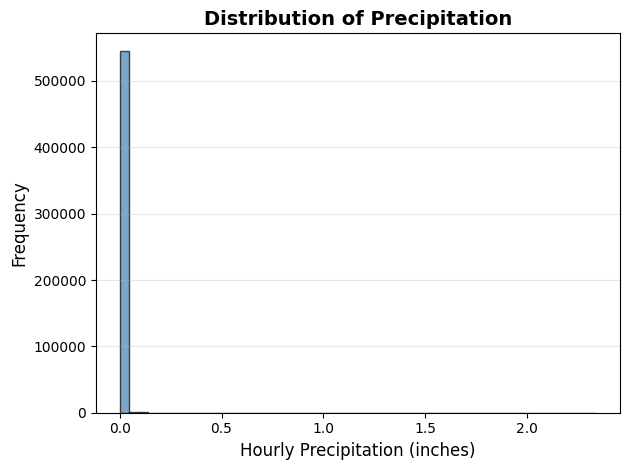

In [8]:
# we first need to convert the data type of precipitation to 'numeric' in order to make the histogram
df_raw['p01i'] = pd.to_numeric(df_raw['p01i'], errors='coerce')
plt.hist(df_raw['p01i'].dropna(), bins=50, color='steelblue', edgecolor='black', alpha=0.7)
plt.xlabel('Hourly Precipitation (inches)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Precipitation', fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

As we expected, a lot of days in Arizona show no rain at all. There are around 100 days with 0.05 inches of rain, and very less days with more than 0.2 inches of rain.

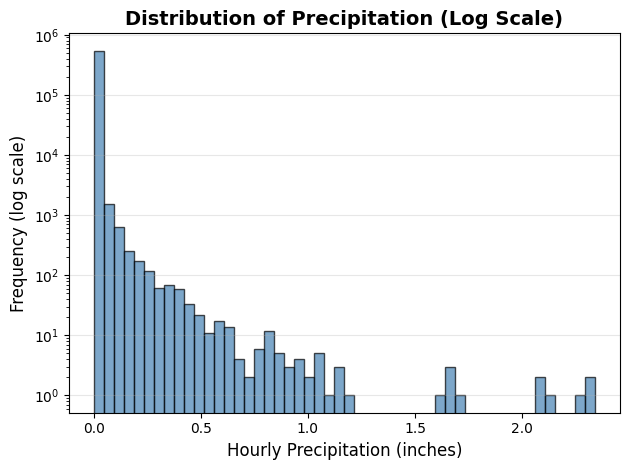

In [9]:
plt.hist(df_raw['p01i'].dropna(), bins=50, color='steelblue', edgecolor='black', alpha=0.7)
plt.xlabel('Hourly Precipitation (inches)', fontsize=12)
plt.ylabel('Frequency (log scale)', fontsize=12)
plt.title('Distribution of Precipitation (Log Scale)', fontsize=14, fontweight='bold')
plt.yscale('log')  # Log scale for better visualization
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

This is a histogram that studies the same exact thing as above, but this one is more readable and informative. When a particular field has lots of zeroes, the log scale histogram is a good choice because it helps to highlight the non-zero values in a better fashion by changing the y-scale. We can see some rare days where it rained more than 0.6 inches. However, I do not personally think that these are outliers.

Next, we see histogram for Sea Level pressure. In meteorology, falling sea level pressure is a classic indicator of approaching weather systems and precipitation. Low pressure systems bring clouds and rain.

Text(0.5, 1.0, 'Distribution of Atmospheric Pressure')

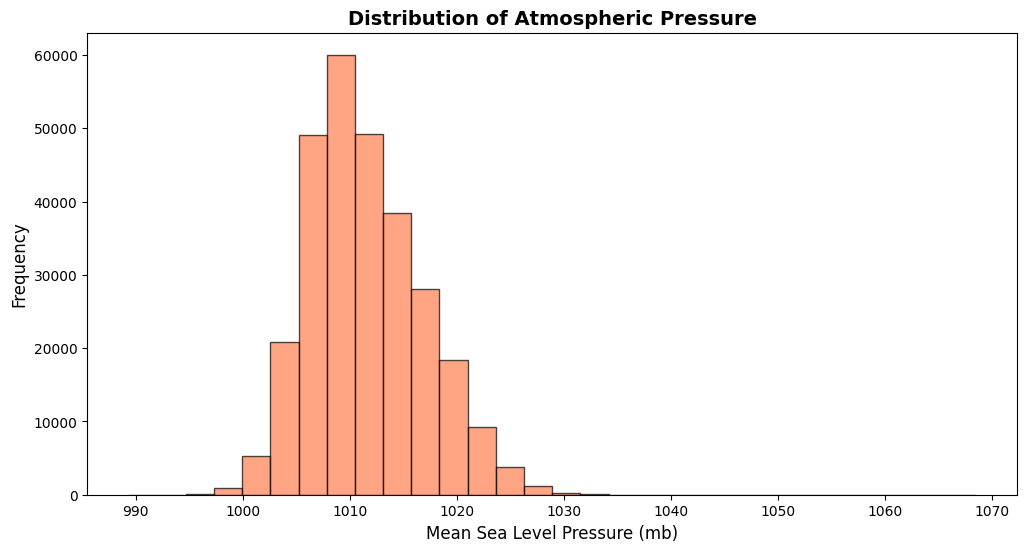

In [10]:
# we first need to convert the type to numeric so that we can see the histogram
df_raw['mslp'] = pd.to_numeric(df_raw['mslp'], errors='coerce')
plt.figure(figsize=(12, 6))
plt.hist(df_raw['mslp'].dropna(), bins=30, color='coral', edgecolor='black', alpha=0.7)
plt.xlabel('Mean Sea Level Pressure (mb)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Atmospheric Pressure', fontsize=14, fontweight='bold')


We see a bell shaped normal distribution.
The atmospheric pressure in Arizona has most readings concentrated between 1005-1015 mb. The peak occurs around 1010 mb, which is close to standard sea level pressure (1013 mb), indicating typical weather conditions dominate. The distribution shows relatively few extreme low pressure values (below 1000 mb), suggesting that stormy weather with heavy rain is less common in this desert location.

Next, let us look at a pie chart to show how many hours saw some rainfall in Arizona.

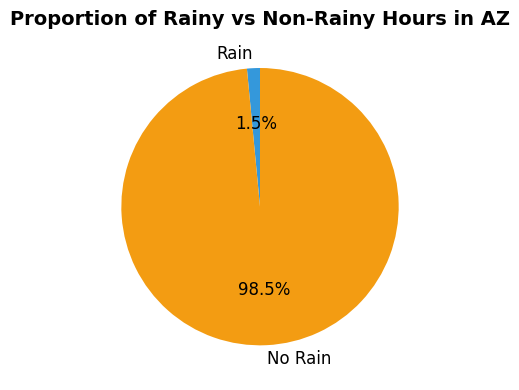

In [11]:
rain_count = (df_raw['p01i'] > 0).sum() # rows with this column > 0 will show some rainfall
no_rain_count = (df_raw['p01i'] == 0).sum()

plt.figure(figsize=(4,4))
plt.pie([rain_count, no_rain_count],
        labels=['Rain', 'No Rain'],
        autopct='%1.1f%%',
        colors=['#3498db', '#f39c12'],
        startangle=90,
        textprops={'fontsize': 12})
plt.title('Proportion of Rainy vs Non-Rainy Hours in AZ', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

As we expected, more than 2/3rd hours in the 25 years did not see any rainfall (milestone 1). The pie chart changed after doing milestone 2 I do not know why.

Next, let's look at a box plot about the precipitation. This box plot might help us to identify any outliers.

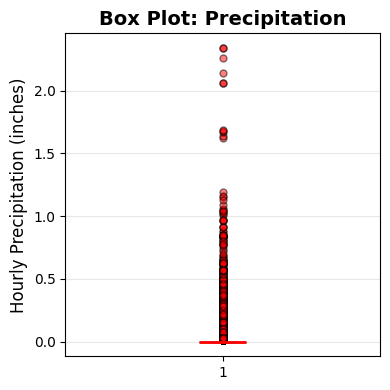

In [12]:
plt.figure(figsize=(4,4))
# using the box plot function as it is from the demos.
plt.boxplot(df_raw['p01i'].dropna(), vert=True, patch_artist=True,
            boxprops=dict(facecolor='lightblue', alpha=0.7),
            medianprops=dict(color='red', linewidth=2),
            flierprops=dict(marker='o', markerfacecolor='red', markersize=5, alpha=0.5))
plt.ylabel('Hourly Precipitation (inches)', fontsize=12)
plt.title('Box Plot: Precipitation', fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

This box plot again reiterates our findings from the histogram. Again, 0.6 inches of rainfall is highly possible and doesn't seem to be an error, so it is not an outlier.

Now, let us revisit our study about the relation between pressure and rainfall. Let us see a preliminary scatter plot to check our claims.

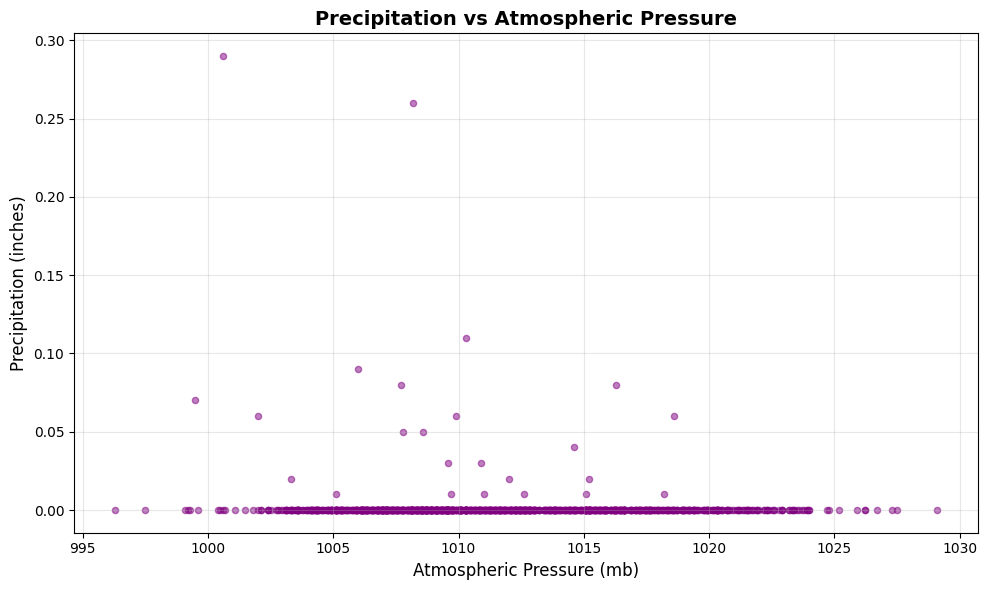

In [13]:
# Sample data for faster plotting, instead of plotting all 70K entries
sample_size = min(5000, len(df_raw))
sample = df_raw.sample(sample_size)

plt.figure(figsize=(10, 6))
plt.scatter(sample['mslp'], sample['p01i'], alpha=0.5, s=20, color='purple')
plt.xlabel('Atmospheric Pressure (mb)', fontsize=12)
plt.ylabel('Precipitation (inches)', fontsize=12)
plt.title('Precipitation vs Atmospheric Pressure', fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

We can see no clear linear relationship. We will investigate this further using regression. A thing we can note here is that the heaviest rainfall correspond to the lowest atmospheric pressure, so something we can explore further.

# Part 3 - Data Cleaning

We first begin by identifying NA values and removing them. We see that NA values are marked as 'M' in our dataset.

In [14]:
df = df_raw.replace('M', np.nan) # replacing 'M' with NaN
df = df.replace('', np.nan)

# we then count missing values
missing_data = pd.DataFrame({
    'Column': df.columns,
    'Missing_Count': df.isnull().sum().values, # finding total number of missing
    'Missing_Percentage': (df.isnull().sum().values / len(df) * 100).round(2)
})

# we only want to show columns with missing data
missing_data = missing_data[missing_data['Missing_Count'] > 0].sort_values(
    'Missing_Percentage', ascending=False
)

print("\nColumns with Missing Values:")
print(missing_data.to_string(index=False))
print(f"\nTotal columns with missing data: {len(missing_data)}")


Columns with Missing Values:
           Column  Missing_Count  Missing_Percentage
ice_accretion_3hr         769199              100.00
ice_accretion_6hr         769199              100.00
        snowdepth         769199              100.00
ice_accretion_1hr         769199              100.00
   peak_wind_gust         762742               99.16
   peak_wind_time         762741               99.16
   peak_wind_drct         762741               99.16
            skyl4         758698               98.63
          wxcodes         748097               97.26
             gust         718741               93.44
            skyl3         704522               91.59
            skyc4         587687               76.40
            skyl2         578109               75.16
            skyc3         536376               69.73
             mslp         484437               62.98
            skyc2         447927               58.23
            skyl1         376656               48.97
             p01

A surprising fact we see here is that out of the 70K rows, around 68K rows are NA values for the precipitation column. We need to get rid of these rows. They are mostly data from the yeara 2000-2010. The remaining 2K rows are latest data, which is better for our model. The NA values in irrelevant columns don't matter because I will drop these columns anyway.

In [15]:
# Removing rows with NA in precipitation
df = df.dropna(subset=['p01i'])
print(len(df))

547583


Next, we check for outliers. Let us use the 'IQR' method as used in the demos to see for outliers in each column.

In [16]:
# Convert numerical columns to numeric (will do this again in feature engineering)
numerical_cols = ['tmpf', 'dwpf', 'relh', 'drct', 'sknt', 'p01i', 'alti', 'mslp', 'vsby']
numerical_cols = [col for col in numerical_cols if col in df.columns]

for col in numerical_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

def detect_outliers_iqr(data, column):
    """Detect outliers using IQR method"""
    # Using the same code from demo
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]

    return len(outliers), lower_bound, upper_bound

# we just Check for outliers in key variables
outlier_columns = ['tmpf', 'dwpf', 'relh', 'sknt', 'p01i', 'mslp']
outlier_columns = [col for col in outlier_columns if col in df.columns]

print("\nOutlier Detection (IQR Method):")

print(f"{'Column':<15} {'Count':<10} {'Percentage':<12} {'Lower':<12} {'Upper':<12}")


outlier_summary = {}
for col in outlier_columns:
    count, lower, upper = detect_outliers_iqr(df, col)
    percentage = (count / len(df)) * 100
    outlier_summary[col] = {
        'count': count,
        'percentage': percentage,
        'lower': lower,
        'upper': upper
    }
    print(f"{col:<15} {count:<10} {percentage:<12.2f} {lower:<12.2f} {upper:<12.2f}")



Outlier Detection (IQR Method):
Column          Count      Percentage   Lower        Upper       
tmpf            2          0.00         17.60        132.80      
dwpf            721        0.13         -3.40        81.40       
relh            20140      3.68         -21.93       83.08       
sknt            11172      2.04         -4.50        15.50       
p01i            8242       1.51         0.00         0.00        
mslp            1177       0.21         996.95       1025.35     


We see some outliers in some columns, but we do not fix those in precipitation because those are possible rare values and not outliers. We fix outliers for humidity and wind speed. These can't be negative.

In [17]:
df['relh'] = df['relh'].clip(0, 100)
df = df[df['sknt'] >= 0]

Next, we remove less relevant columns. There are currently 30 columns, and a lot of them which we do not need. So we will remove them.

In [18]:
unnecessary_columns = [
    'metar',            # Raw METAR string - already parsed into other columns
    'skyc1', 'skyc2', 'skyc3', 'skyc4',  # Sky condition codes - complex, use visibility instead
    'skyl1', 'skyl2', 'skyl3', 'skyl4',  # Sky level heights - not needed
    'wxcodes',          # Weather codes - complex string, hard to use
    'ice_accretion_1hr', 'ice_accretion_3hr', 'ice_accretion_6hr',  # Ice - not relevant for rain
    'peak_wind_gust',   # Duplicate of gust
    'peak_wind_drct',   # Peak wind direction - not critical
    'peak_wind_time',   # Timestamp of peak - not needed
    'feel',             # "Feels like" temperature - derived value
    'snowdepth',        # Snow - not relevant in Phoenix
    'gust',             # Gust - not relevant in Phoenix
]

# Only drop columns that actually exist in the dataframe
cols_to_drop_unnecessary = [col for col in unnecessary_columns if col in df.columns]
df = df.drop(columns=cols_to_drop_unnecessary)
print(df.head())


    station             valid  tmpf  dwpf   relh   drct  sknt  p01i   alti  \
0       PHX  2000-01-01 00:00  67.0  32.0  27.07  330.0   4.0  0.00  29.91   
15      PHX  2000-01-01 07:00  56.0  35.0  45.06  100.0   4.0  0.00  29.89   
81      PHX  2000-01-02 13:56  45.0  37.0  73.59    0.0   0.0  0.01  29.97   
196     PHX  2000-01-04 15:00  41.0  14.0  32.88    0.0   0.0  0.00  30.42   
458     PHX  2000-01-09 13:00  38.0  23.0  54.39  120.0   3.0  0.00  30.15   

       mslp  vsby  
0    1012.1  10.0  
15   1011.3   9.0  
81   1014.4   8.0  
196     NaN   9.0  
458  1020.9  10.0  


Let us see how the dataframe looks like after cleaning.

In [19]:
# we then count missing values
missing_data = pd.DataFrame({
    'Column': df.columns,
    'Missing_Count': df.isnull().sum().values, # finding total number of missing
    'Missing_Percentage': (df.isnull().sum().values / len(df) * 100).round(2)
})

# we only want to show columns with missing data
missing_data = missing_data[missing_data['Missing_Count'] > 0].sort_values(
    'Missing_Percentage', ascending=False
)

print("\nColumns with Missing Values:")
print(missing_data.to_string(index=False))
print(f"\nTotal columns with missing data: {len(missing_data)}")


Columns with Missing Values:
Column  Missing_Count  Missing_Percentage
  mslp         364984               67.01
  drct          21102                3.87
  relh          10567                1.94
  dwpf          10234                1.88
  tmpf           7603                1.40
  vsby           3979                0.73
  alti            405                0.07

Total columns with missing data: 7


We see that there are still NA values in other important columns. So what we do is, we create another dataframe called df_2. This df_2 will store all important columns and ZERO NA values. I want to keep the df_2 separate bcoz df stores all data with precipitation values. I do not want to reduce that data. Whenever we are doing analysis of something other than precipitation, I will use df_2.

In [20]:
critical_columns = ['valid', 'tmpf', 'dwpf', 'relh', 'p01i', 'mslp']
df_2 = df.dropna(subset=critical_columns)
print(len(df_2))

179626


# Part 4 - Feature Engineering

In this part, we will first begin with adjusting the data types of all the columns. All columns were originally 'object' and we need to fix that.

In [21]:
# Convert numerical columns to numeric
numerical_cols = ['tmpf', 'dwpf', 'relh', 'drct', 'sknt', 'p01i', 'alti', 'mslp', 'vsby']
numerical_cols = [col for col in numerical_cols if col in df.columns]

for col in numerical_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# doing the same for df_2
numerical_cols2 = ['tmpf', 'dwpf', 'relh', 'drct', 'sknt', 'p01i', 'alti', 'mslp', 'vsby']
for col in numerical_cols2:
    df_2[col] = pd.to_numeric(df_2[col], errors='coerce')

Next, we see that the df has a column called 'valid'. This column has date and time. The problem is that there are multiple rows representing different hours for the same day. But, for the scope of our project, we want to focus on only one day at a time. So I will aggregate all rows for a given day.

In [22]:
# Convert 'valid' to datetime
df['valid'] = pd.to_datetime(df['valid'])

# Extract date (without time)
df['date'] = df['valid'].dt.date

# Extract day, month, year
df['day'] = df['valid'].dt.day
df['month'] = df['valid'].dt.month
df['year'] = df['valid'].dt.year
df['day_name'] = df['valid'].dt.day_name() # day name will return the day name

print(df[['valid', 'date', 'day', 'month', 'year', 'p01i', 'day_name']].head())

                  valid        date  day  month  year  p01i  day_name
0   2000-01-01 00:00:00  2000-01-01    1      1  2000  0.00  Saturday
15  2000-01-01 07:00:00  2000-01-01    1      1  2000  0.00  Saturday
81  2000-01-02 13:56:00  2000-01-02    2      1  2000  0.01    Sunday
196 2000-01-04 15:00:00  2000-01-04    4      1  2000  0.00   Tuesday
458 2000-01-09 13:00:00  2000-01-09    9      1  2000  0.00    Sunday


Next we will aggregate the data so that hourly are added to become daily.

In [23]:
# Aggregate hourly → daily
# we will use the agg function to do this. we will add up precipitation, take average of the temperature.
# take mean of all other features as well.
print(f"Before aggregation: {len(df):,} rows (hourly data)")

df_daily = df.groupby('date').agg({
    'p01i': 'sum',                    # Total daily precipitation
    'tmpf': ['mean', 'min', 'max'],   # Temperature stats
    'dwpf': 'mean',                   # Average dew point
    'relh': 'mean',                   # Average humidity
    'sknt': ['mean', 'max'],          # Wind speed stats
    'drct': 'mean',                   # Average wind direction
    'mslp': 'mean',                   # Average pressure
    'vsby': 'mean',                   # Average visibility (if you have it)
    # Add any other columns you want to aggregate
}).reset_index()

# Flatten the multi-level column names
df_daily.columns = ['_'.join(col).strip('_') if col[1] else col[0]
                     for col in df_daily.columns.values]

# Rename columns for clarity in this new dataframe
df_daily = df_daily.rename(columns={
    'p01i_sum': 'daily_precip',
    'tmpf_mean': 'temp_avg',
    'tmpf_min': 'temp_min',
    'tmpf_max': 'temp_max',
    'dwpf_mean': 'dewpoint_avg',
    'relh_mean': 'humidity_avg',
    'sknt_mean': 'wind_speed_avg',
    'sknt_max': 'wind_speed_max',
    'drct_mean': 'wind_dir_avg',
    'mslp_mean': 'pressure_avg',
    'vsby_mean': 'visibility_avg'
})

print(f"After aggregation: {len(df_daily):,} rows (daily data)")
print(f"Reduction factor: {len(df)/len(df_daily):.1f}x\n")

# Now extract day, month, year from the daily data, after we aggregated it
df_daily['date'] = pd.to_datetime(df_daily['date'])
df_daily['day'] = df_daily['date'].dt.day
df_daily['month'] = df_daily['date'].dt.month
df_daily['year'] = df_daily['date'].dt.year
df_daily['day_name'] = df_daily['date'].dt.day_name()

# Preview
print("First 5 days of aggregated data:")
print(df_daily.head())

print(f"\nColumns in daily data: {list(df_daily.columns)}")

Before aggregation: 544,655 rows (hourly data)
After aggregation: 7,668 rows (daily data)
Reduction factor: 71.0x

First 5 days of aggregated data:
        date  daily_precip  temp_avg  temp_min  temp_max  dewpoint_avg  \
0 2000-01-01          0.00      61.5      56.0      67.0          33.5   
1 2000-01-02          0.01      45.0      45.0      45.0          37.0   
2 2000-01-04          0.00      41.0      41.0      41.0          14.0   
3 2000-01-09          0.00      38.0      38.0      38.0          23.0   
4 2000-01-10          0.00      61.0      60.0      62.0          21.0   

   humidity_avg  wind_speed_avg  wind_speed_max  wind_dir_avg  pressure_avg  \
0        36.065        4.000000             4.0         215.0        1011.7   
1        73.590        0.000000             0.0           0.0        1014.4   
2        32.880        0.000000             0.0           0.0           NaN   
3        54.390        3.000000             3.0         120.0        1020.9   
4        21.

In [24]:
# we need to reflect these feature engineering in df_2
df_2_daily = df_daily.dropna()

Another feature engineering we can do here is creating a feature called 'Pressure Lag'. This will be a new column that will contain information about pressure on the previous day, and the change in pressure with today. This is important because falling pressure sometimes indicates rainfall.

In [25]:
df_daily = df_daily.sort_values('date').reset_index(drop=True)

# Create pressure lag features
df_daily['pressure_yesterday'] = df_daily['pressure_avg'].shift(1)
df_daily['pressure_change'] = df_daily['pressure_avg'] - df_daily['pressure_yesterday']

print("Pressure lag features created:")
print(df_daily[['date', 'pressure_avg', 'pressure_yesterday', 'pressure_change']].head(5))


Pressure lag features created:
        date  pressure_avg  pressure_yesterday  pressure_change
0 2000-01-01        1011.7                 NaN              NaN
1 2000-01-02        1014.4              1011.7              2.7
2 2000-01-04           NaN              1014.4              NaN
3 2000-01-09        1020.9                 NaN              NaN
4 2000-01-10        1019.6              1020.9             -1.3


In [26]:
# doing the same for df_2, this will do not show NaN in the pressure_change calculation

In [27]:
df_2_daily = df_2_daily.sort_values('date').reset_index(drop=True)

# Create pressure lag features
df_2_daily['pressure_yesterday'] = df_2_daily['pressure_avg'].shift(1)
df_2_daily['pressure_change'] = df_2_daily['pressure_avg'] - df_2_daily['pressure_yesterday']

print("Pressure lag features created:")
print(df_2_daily[['date', 'pressure_avg', 'pressure_yesterday', 'pressure_change']].head(5))


Pressure lag features created:
        date  pressure_avg  pressure_yesterday  pressure_change
0 2000-01-01        1011.7                 NaN              NaN
1 2000-01-02        1014.4              1011.7              2.7
2 2000-01-09        1020.9              1014.4              6.5
3 2000-01-10        1019.6              1020.9             -1.3
4 2000-01-19        1016.5              1019.6             -3.1


In [28]:
df_2_daily.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6353 entries, 0 to 6352
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   date                6353 non-null   datetime64[ns]
 1   daily_precip        6353 non-null   float64       
 2   temp_avg            6353 non-null   float64       
 3   temp_min            6353 non-null   float64       
 4   temp_max            6353 non-null   float64       
 5   dewpoint_avg        6353 non-null   float64       
 6   humidity_avg        6353 non-null   float64       
 7   wind_speed_avg      6353 non-null   float64       
 8   wind_speed_max      6353 non-null   float64       
 9   wind_dir_avg        6353 non-null   float64       
 10  pressure_avg        6353 non-null   float64       
 11  visibility_avg      6353 non-null   float64       
 12  day                 6353 non-null   int32         
 13  month               6353 non-null   int32       

# Milestone 2
Step 1 - Model selection

My Project Goal:
I want to predict daily rainfall amount (in inches) for Arizona using weather feature.

Model type to use:
- Regression (continuous target variable: rainfall amount)

Dataset characteristics:
- Type: Tabular weather data (temperature, humidity, pressure, wind, etc.)
- Features: ~15+ numerical weather measurements and engineered features
- Target: daily_precip (continuous, 0 to ~0.6 inches)
- Samples: ~7,000 days of historical weather data after 2000 year
- Training approach: 80/20 train-test split

SELECTED MODEL:
Multiple Linear Regression

JUSTIFICATION:

Strengths (based on the demo file in class):
- Works well with continuous numerical features
- Interpretability - Shows which weather variables influence rainfall
- Fast to train and evaluate
- Feature coefficients reveal physical relationships (e.g., pressure drop → rain)
- Easy to explain to stakeholders as it consists line graphs

Weaknesses (from PPT in class):
- Assumes linear relationships (weather can be non-linear)
- Cannot automatically capture feature interactions
- Sensitive to multicollinearity between correlated weather features

Why Multiple Linear Regression is appropriate for this project:
1. Weather variables (pressure, temperature, humidity) have known linear
   relationships with precipitation, as I researched on Google
2. Model interpretability is valuable - we can explain exactly WHY it predicts rain, and it can be explicit with no hidden layers
3. More importantly, I see that it serves as a strong baseline before attempting more complex models (ANN) in the next model
4. Coefficients can be validated against meteorological knowledge

# Step 2 - Model Training

In [29]:
# importing libraries for model training
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.feature_selection import SequentialFeatureSelector

In [30]:
# calling the dataframe as DF for simplicity
DF = df_2_daily
DF = DF.dropna() # we can't do regression with NaN values

# adding a new column isMonsoon (might come handy for feature analysis)
DF['is_monsoon'] = DF['month'].isin([7, 8, 9]).astype(int)

# we know that there are some columns to  be excluded from features (X variable)
exclude_cols = [
    'date', 'valid',         # Timestamps
    'daily_precip',          # Target variable
    'rained',                # Derived from target
    'rain_intensity',        # Derived from target
    'day_name', 'season',    # Text (already one-hot encoded)
    'humidity_category',     # Text (already one-hot encoded)
    'temp_category',         # Text (already one-hot encoded)
    'pressure_category'      # Text (already one-hot encoded)
]

# Selecting numerical features (Y variable)
feature_cols = [col for col in DF.columns if col not in exclude_cols]
X = DF[feature_cols].copy()
y = DF['daily_precip'].copy()

# Split: 80% training, 20% testing (our milestone requirements)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

In [31]:
# Taking some helper functions from the MLR demo ipynb file by Prof

def model_results(name, model, X_train, X_test, y_train, y_test, feature_names):
    """
    Train model and display comprehensive results
    Adapted from MLR_Demo.ipynb
    """
    # Fit model
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Raw coefficients
    raw_coefs = dict(zip(feature_names, model.coef_))

    # Standardized coefficients β* = β_j * (σ_xj / σ_y)
    if isinstance(X_train, pd.DataFrame):
        sx = X_train.std(axis=0, ddof=0).values
    else:
        sx = X_train.std(axis=0, ddof=0)
    sy = np.std(y_train, ddof=0)
    std_coefs = {f: b * (sx[i] / sy) for i, (f, b) in enumerate(zip(feature_names, model.coef_))}

    # Metrics
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)

    # Print results
    print(f"\n{'='*80}")
    print(f"{name}")
    print(f"{'='*80}")
    print(f"Intercept: {model.intercept_:.6f}")

    # Show top coefficients by absolute value
    print(f"\nTop 10 Features by Absolute Raw Coefficient:")
    sorted_coefs = sorted(raw_coefs.items(), key=lambda x: abs(x[1]), reverse=True)
    for feat, coef in sorted_coefs[:10]:
        print(f"  {feat:35s}: {coef:10.6f}")

    print(f"\nTop 10 Features by Absolute Standardized Coefficient (β*):")
    sorted_std = sorted(std_coefs.items(), key=lambda x: abs(x[1]), reverse=True)
    for feat, coef in sorted_std[:10]:
        print(f"  {feat:35s}: {coef:10.6f}")

    print(f"\n{'-'*80}")
    print("PERFORMANCE METRICS:")
    print(f"{'-'*80}")
    print(f"R² Score:  {r2:.6f}")
    print(f"MSE:       {mse:.6f}")
    print(f"RMSE:      {rmse:.6f}")
    print(f"MAE:       {mae:.6f}")

    return model, y_pred, r2, mse, rmse, mae, raw_coefs, std_coefs


def plot_standardized_coefs(model, X_train, y_train, feature_names, title="Standardized Coefficients", top_n=15):
    """
    Plot standardized coefficients
    Adapted from MLR_Demo.ipynb
    """
    # Compute standardized coefficients
    if isinstance(X_train, pd.DataFrame):
        sx = X_train.std(axis=0, ddof=0).values
    else:
        sx = X_train.std(axis=0, ddof=0)
    sy = np.std(y_train, ddof=0)

    std_coefs = [b * (sx[i] / sy) for i, b in enumerate(model.coef_)]

    # Create dataframe and get top N
    coef_df = pd.DataFrame({
        'feature': feature_names,
        'std_coef': std_coefs
    })
    coef_df['abs_coef'] = coef_df['std_coef'].abs()
    coef_df = coef_df.sort_values('abs_coef', ascending=False).head(top_n)

    # Plot
    plt.figure(figsize=(10, 6))
    colors = ['green' if x > 0 else 'red' for x in coef_df['std_coef']]
    plt.barh(coef_df['feature'], coef_df['std_coef'], color=colors, alpha=0.7, edgecolor='black')
    plt.axvline(0, color="black", linewidth=1)
    plt.xlabel("Standardized Coefficient (β*)", fontsize=12)
    plt.ylabel("Features", fontsize=12)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

    # Print
    print(f"\n{title}:")
    for _, row in coef_df.iterrows():
        print(f"  {row['feature']:35s}: {row['std_coef']:10.6f}")


def plot_predictions(y_test, y_pred, title="Actual vs Predicted"):
    """
    Scatter plot of actual vs predicted values
    """
    plt.figure(figsize=(8, 8))
    plt.scatter(y_test, y_pred, alpha=0.5, s=20, color='steelblue', edgecolor='black', linewidth=0.5)

    # Perfect prediction line
    min_val = min(y_test.min(), y_pred.min())
    max_val = max(y_test.max(), y_pred.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')

    plt.xlabel('Actual Rainfall (inches)', fontsize=12)
    plt.ylabel('Predicted Rainfall (inches)', fontsize=12)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


def plot_residuals(y_test, y_pred, title="Residual Plot"):
    """
    Plot residuals to check for patterns
    """
    residuals = y_test - y_pred

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Residuals vs Predicted
    axes[0].scatter(y_pred, residuals, alpha=0.5, s=20, color='coral', edgecolor='black', linewidth=0.5)
    axes[0].axhline(0, color='black', linestyle='--', linewidth=2)
    axes[0].set_xlabel('Predicted Rainfall (inches)', fontsize=11)
    axes[0].set_ylabel('Residuals (inches)', fontsize=11)
    axes[0].set_title('Residuals vs Predicted', fontsize=12, fontweight='bold')
    axes[0].grid(alpha=0.3)

    # Histogram of residuals
    axes[1].hist(residuals, bins=50, color='lightgreen', edgecolor='black', alpha=0.7)
    axes[1].set_xlabel('Residuals (inches)', fontsize=11)
    axes[1].set_ylabel('Frequency', fontsize=11)
    axes[1].set_title('Distribution of Residuals', fontsize=12, fontweight='bold')
    axes[1].axvline(0, color='red', linestyle='--', linewidth=2)
    axes[1].grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

In [32]:
DF.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6352 entries, 1 to 6352
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   date                6352 non-null   datetime64[ns]
 1   daily_precip        6352 non-null   float64       
 2   temp_avg            6352 non-null   float64       
 3   temp_min            6352 non-null   float64       
 4   temp_max            6352 non-null   float64       
 5   dewpoint_avg        6352 non-null   float64       
 6   humidity_avg        6352 non-null   float64       
 7   wind_speed_avg      6352 non-null   float64       
 8   wind_speed_max      6352 non-null   float64       
 9   wind_dir_avg        6352 non-null   float64       
 10  pressure_avg        6352 non-null   float64       
 11  visibility_avg      6352 non-null   float64       
 12  day                 6352 non-null   int32         
 13  month               6352 non-null   int32         
 1

MODEL 1: BASELINE - PRESSURE CHANGE ONLY
Using only 'pressure_change' (yesterday's pressure - today's pressure)
Meteorological approach we know: Falling pressure indicates approaching rain

Baseline Model: Pressure Change Only
Intercept: 0.093482

Top 10 Features by Absolute Raw Coefficient:
  pressure_change                    :  -0.001470

Top 10 Features by Absolute Standardized Coefficient (β*):
  pressure_change                    :  -0.008932

--------------------------------------------------------------------------------
PERFORMANCE METRICS:
--------------------------------------------------------------------------------
R² Score:  -0.011282
MSE:       0.088671
RMSE:      0.297777
MAE:       0.134027


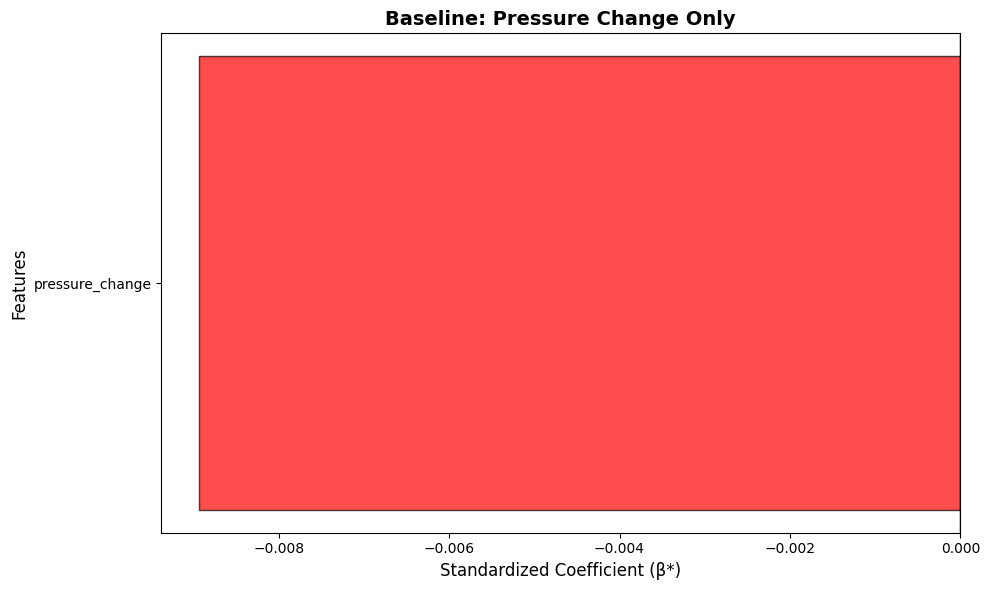


Baseline: Pressure Change Only:
  pressure_change                    :  -0.008932


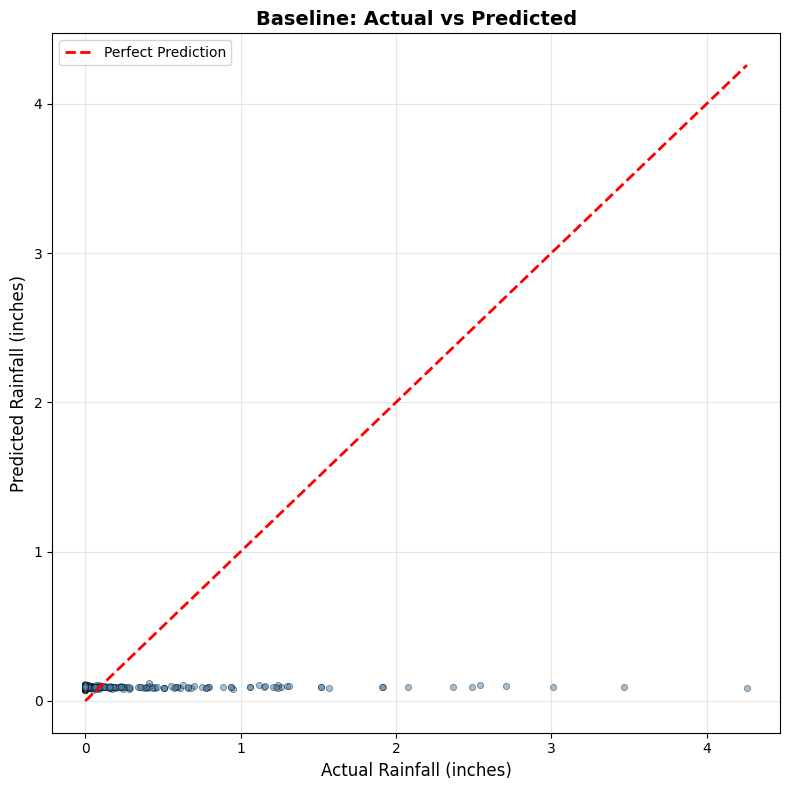

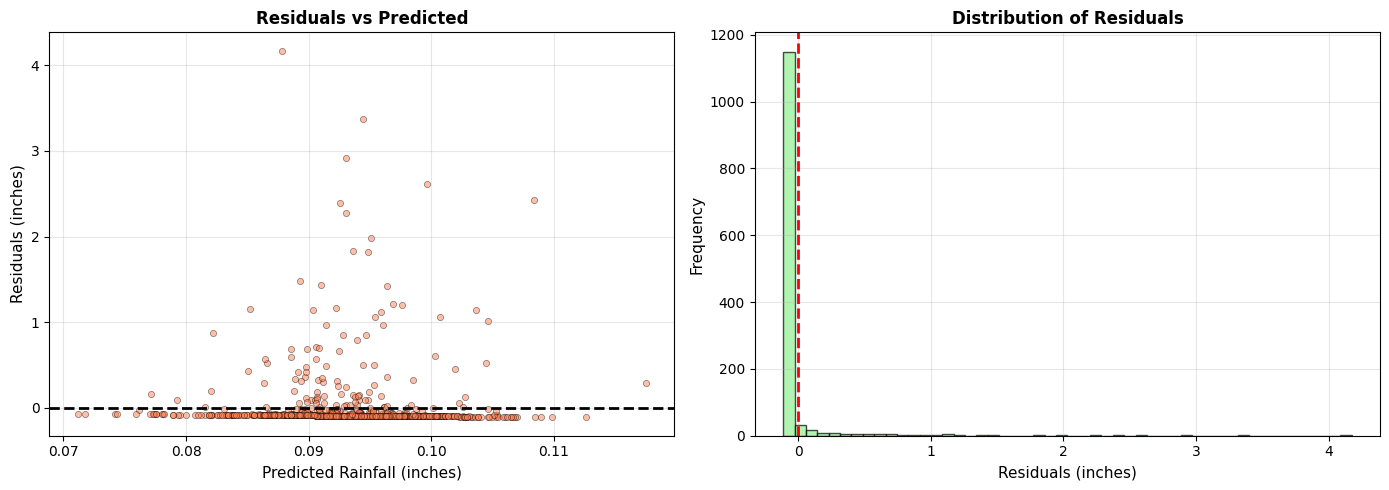

In [33]:
# MODEL 1: BASELINE - SINGLE FEATURE REGRESSION(PRESSURE CHANGE)

print("MODEL 1: BASELINE - PRESSURE CHANGE ONLY")
print("=" * 80)
# something that I was investigating in the EDA part
print("Using only 'pressure_change' (yesterday's pressure - today's pressure)")
print("Meteorological approach we know: Falling pressure indicates approaching rain")

X_train_baseline = X_train[['pressure_change']]
X_test_baseline = X_test[['pressure_change']]

# using Linear Regression like in the demo file
model_baseline, y_pred_baseline, r2_baseline, mse_baseline, rmse_baseline, mae_baseline, _, _ = model_results(
    "Baseline Model: Pressure Change Only",
    LinearRegression(),
    X_train_baseline, X_test_baseline,
    y_train, y_test,
    ['pressure_change']
)

plot_standardized_coefs(model_baseline, X_train_baseline, y_train,
                       ['pressure_change'],
                       title="Baseline: Pressure Change Only")

plot_predictions(y_test, y_pred_baseline, "Baseline: Actual vs Predicted")
plot_residuals(y_test, y_pred_baseline, "Baseline: Residual Analysis")

This model performs ***extremely poorly, with a negative R² score of -0.011***, indicating that the model performs worse than simply predicting the mean rainfall for all observations. ***The standardized coefficient of -0.00893 shows that pressure change has minimal predictive power for daily rainfall amounts***, and the scatter plot reveals that the model predicts nearly constant values close to zero regardless of actual rainfall. The residual plot confirms systematic prediction errors, with the model failing to capture the variability in rainfall, particularly for days with actual precipitation, suggesting that pressure change alone is insufficient for accurate rainfall prediction and additional meteorological features are needed.


MODEL 2: HUMIDITY + MONSOON SEASON
Testing if humidity combined with monsoon season indicator improves prediction

Two-Feature Model: Humidity + Monsoon Season
Intercept: -0.235886

Top 10 Features by Absolute Raw Coefficient:
  is_monsoon                         :   0.076840
  humidity_avg                       :   0.009049

Top 10 Features by Absolute Standardized Coefficient (β*):
  humidity_avg                       :   0.313559
  is_monsoon                         :   0.059846

--------------------------------------------------------------------------------
PERFORMANCE METRICS:
--------------------------------------------------------------------------------
R² Score:  0.088755
MSE:       0.079900
RMSE:      0.282666
MAE:       0.147810


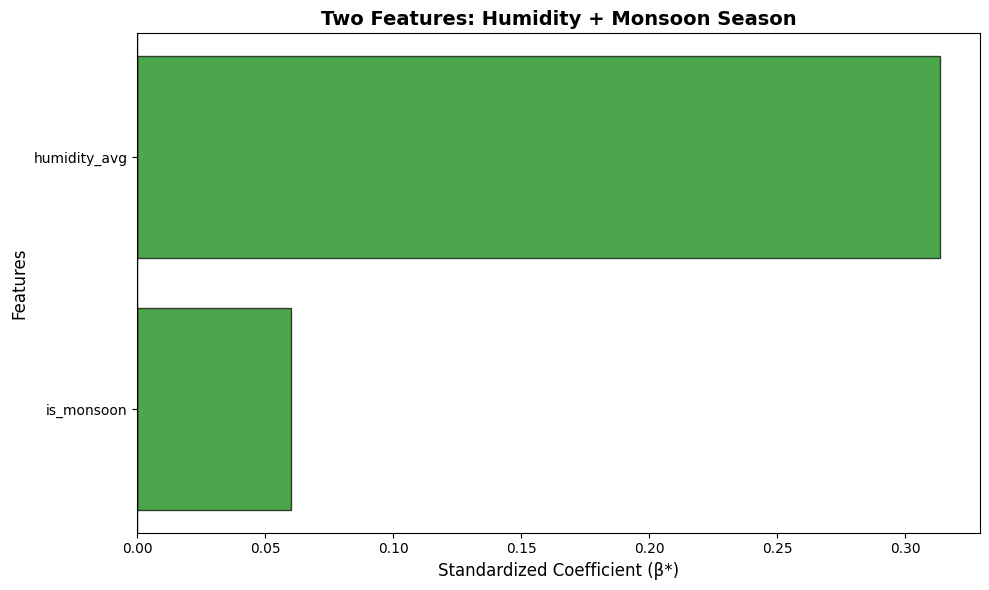


Two Features: Humidity + Monsoon Season:
  humidity_avg                       :   0.313559
  is_monsoon                         :   0.059846


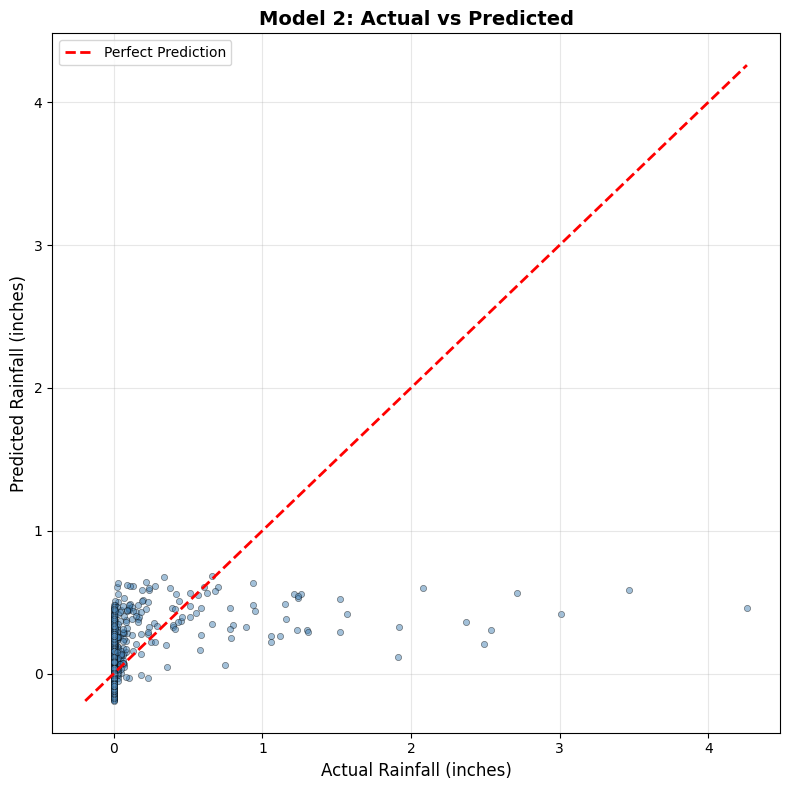

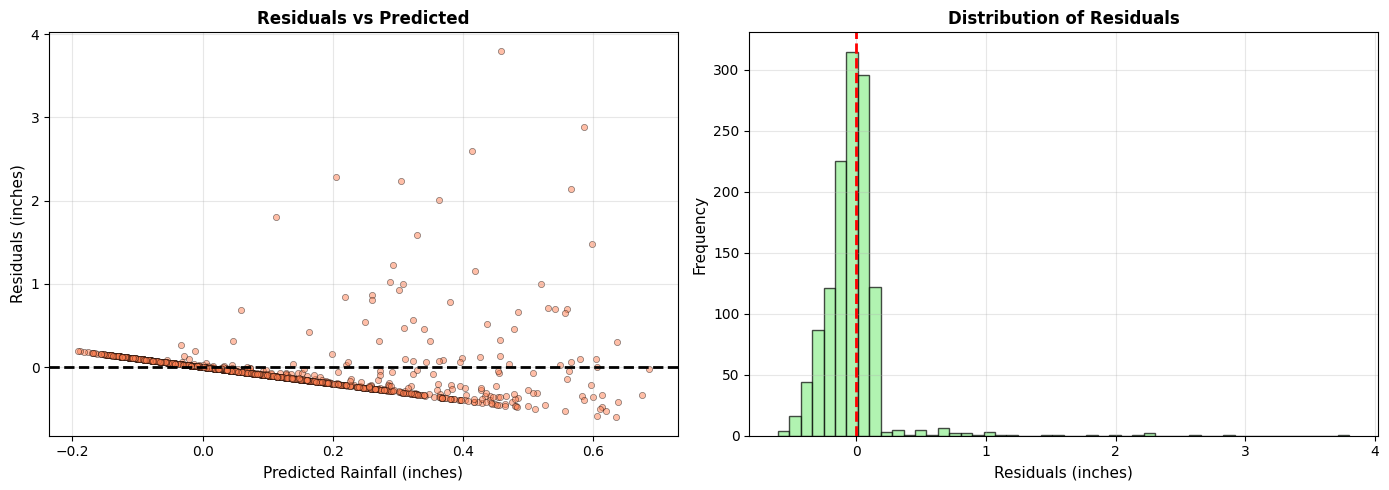

In [34]:
# MODEL 2: TWO FEATURES (PRESSURE CHANGE + HUMIDITY)


print("\n" + "="*80)
print("MODEL 2: HUMIDITY + MONSOON SEASON")
print("="*80)
print("Testing if humidity combined with monsoon season indicator improves prediction")

X_train_two = X_train[['humidity_avg', 'is_monsoon']]
X_test_two = X_test[['humidity_avg', 'is_monsoon']]

model_two, y_pred_two, r2_two, mse_two, rmse_two, mae_two, _, _ = model_results(
    "Two-Feature Model: Humidity + Monsoon Season",
    LinearRegression(),
    X_train_two, X_test_two,
    y_train, y_test,
    ['humidity_avg', 'is_monsoon']
)

plot_standardized_coefs(model_two, X_train_two, y_train,
                       ['humidity_avg', 'is_monsoon'],
                       title="Two Features: Humidity + Monsoon Season")

plot_predictions(y_test, y_pred_two, "Model 2: Actual vs Predicted")
plot_residuals(y_test, y_pred_two, "Model 2: Residual Analysis")


Model 2 shows significant improvement over the model 1, achieving a positive R² score of **0.089**, which indicates that humidity and monsoon season together explain approximately 8.9% of the variance in daily rainfall.** The standardized coefficient plot reveals that humidity (β* = 0.314) is a much stronger predictor than the monsoon season indicator (β* = 0.060)**, suggesting that actual moisture content in the air matters more than the seasonal timing alone. The actual vs predicted plot shows the model can now capture some variability in rainfall amounts rather than predicting near-constant values, though it still struggles with extreme rainfall events (over-predicting low values and under-predicting high values), indicating that additional meteorological features beyond humidity and seasonality are needed for more accurate predictions.


MODEL 3: FULL MODEL (16 FEATURES)
Using all available weather features and engineered variables

Full Model: All 16 Features
Intercept: -6.185501

Top 10 Features by Absolute Raw Coefficient:
  is_monsoon                         :   0.051414
  humidity_avg                       :   0.022971
  wind_speed_avg                     :   0.022292
  dewpoint_avg                       :  -0.018677
  temp_max                           :   0.010979
  temp_min                           :   0.007212
  year                               :   0.005646
  pressure_avg                       :  -0.004861
  month                              :   0.004314
  pressure_change                    :  -0.003214

Top 10 Features by Absolute Standardized Coefficient (β*):
  humidity_avg                       :   0.795942
  dewpoint_avg                       :  -0.489135
  temp_max                           :   0.335130
  temp_min                           :   0.212902
  wind_speed_avg                     :   0.0966

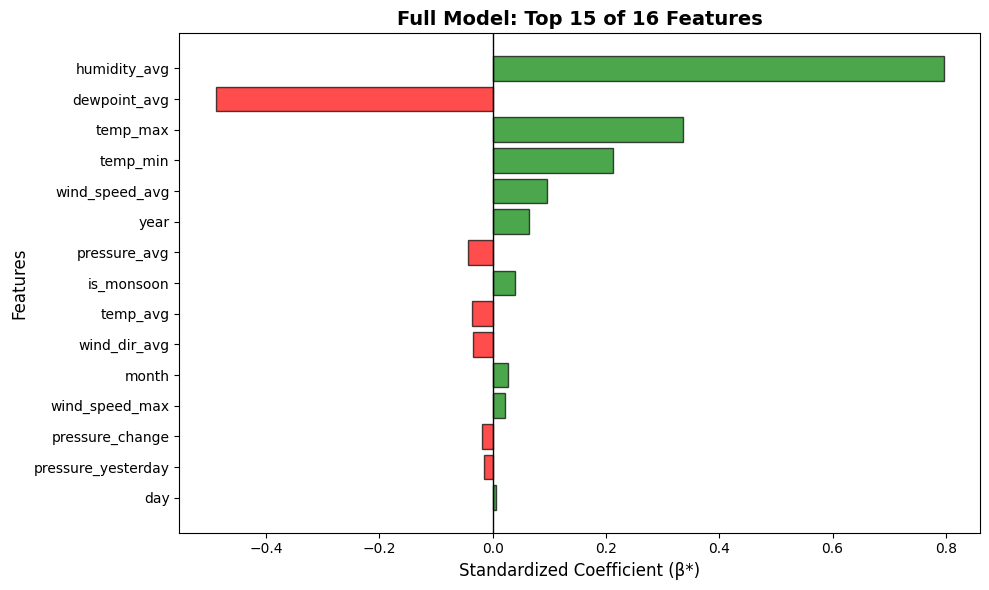


Full Model: Top 15 of 16 Features:
  humidity_avg                       :   0.795942
  dewpoint_avg                       :  -0.489135
  temp_max                           :   0.335130
  temp_min                           :   0.212902
  wind_speed_avg                     :   0.096666
  year                               :   0.063159
  pressure_avg                       :  -0.043332
  is_monsoon                         :   0.040044
  temp_avg                           :  -0.036471
  wind_dir_avg                       :  -0.034152
  month                              :   0.027221
  wind_speed_max                     :   0.022033
  pressure_change                    :  -0.019532
  pressure_yesterday                 :  -0.014723
  day                                :   0.004901


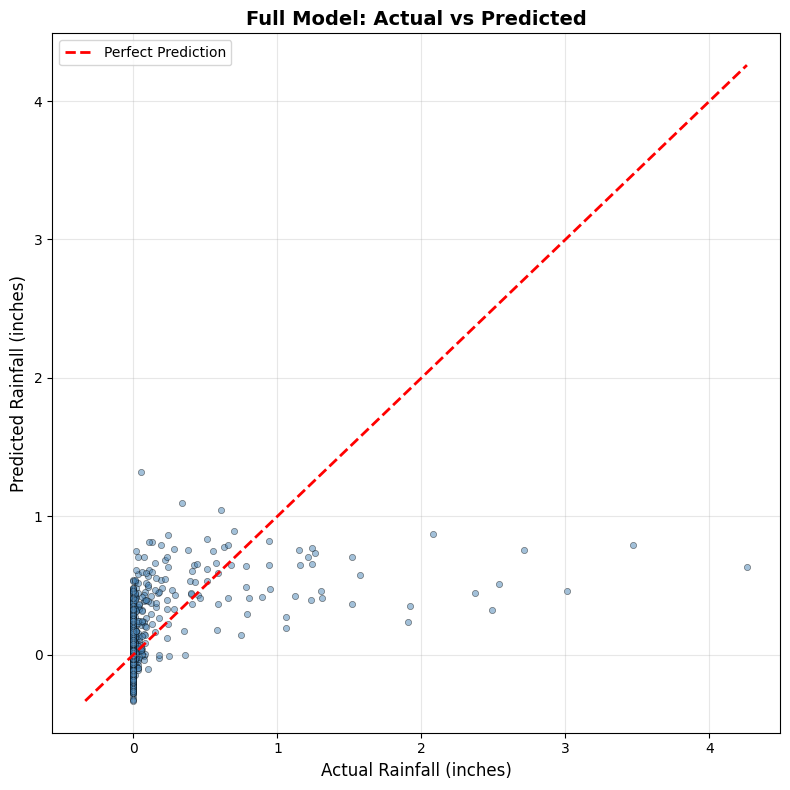

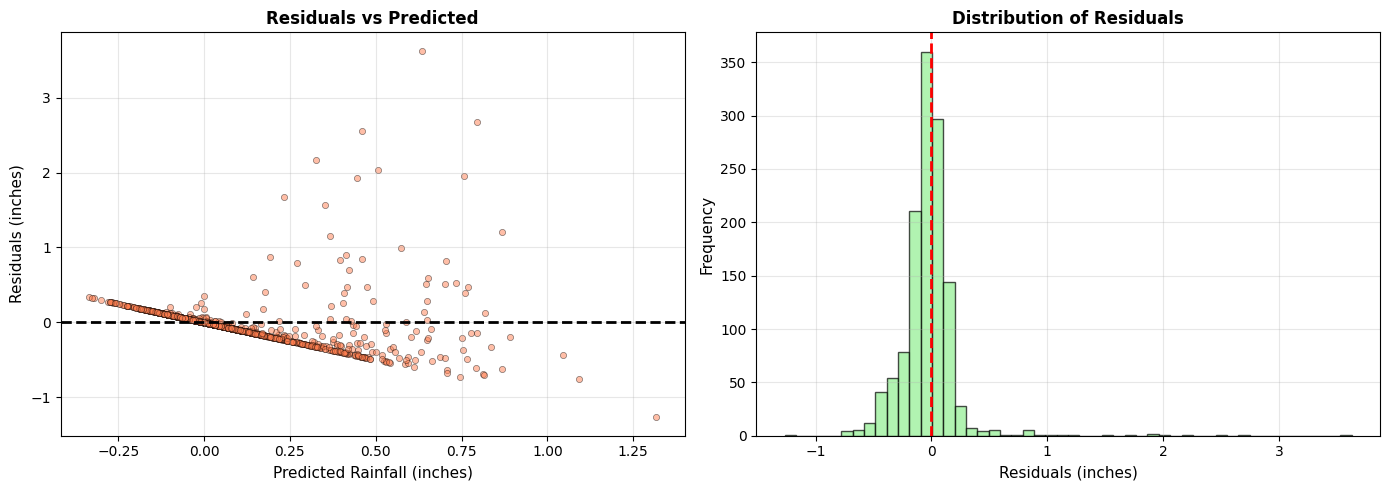

In [35]:
# MODEL 3: FULL MODEL (ALL FEATURES) - following demo file's approach

print("\n" + "="*80)
print(f"MODEL 3: FULL MODEL ({len(feature_cols)} FEATURES)")
print("Using all available weather features and engineered variables")

model_full, y_pred_full, r2_full, mse_full, rmse_full, mae_full, coefs_full, std_coefs_full = model_results(
    f"Full Model: All {len(feature_cols)} Features",
    LinearRegression(),
    X_train, X_test,
    y_train, y_test,
    feature_cols
)

plot_standardized_coefs(model_full, X_train, y_train,
                       feature_cols,
                       title=f"Full Model: Top 15 of {len(feature_cols)} Features",
                       top_n=15)

plot_predictions(y_test, y_pred_full, "Full Model: Actual vs Predicted")
plot_residuals(y_test, y_pred_full, "Full Model: Residual Analysis")


Key Findings:

Overall Performance: The full model achieves R² = 0.128, explaining approximately 12.8% of rainfall variance - a notable improvement over Model 2 (8.9%) and significantly better than the baseline, demonstrating that using multiple weather variables together enhances predictive accuracy.

Most Important Predictors: Humidity (β* = 0.796) is by far the strongest predictor, followed by dewpoint (β* = -0.489) and maximum temperature (β* = 0.335), which aligns with meteorological principles where moisture availability and atmospheric temperature conditions are fundamental to precipitation formation.

Model Limitations: Despite using all available features, the model still explains only 12.8% of rainfall variance, indicating that daily rainfall in Arizona involves complex non-linear patterns and additional factors (like atmospheric dynamics or localized convection) that linear regression cannot capture, suggesting the need for more advanced modeling approaches like neural networks.

Residual Patterns: The residual plot shows the model tends to under-predict high rainfall events (positive residuals for larger actual values) while over-predicting on dry days (negative residuals near zero), which is typical behavior when predicting rare extreme events in weather data with inherent randomness and variability.

In [36]:
# CROSS-VALIDATION AND HYPERPARAMETER OPTIMIZATION like in the demo file, helps to increase the optimization of features

print("CROSS-VALIDATION: FULL MODEL")

# using n = 5
print("Using 5-fold cross-validation to validate model performance")

cv5 = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(LinearRegression(), X_train, y_train,
                             cv=cv5, scoring='r2', n_jobs=-1)

print(f"\n5-Fold Cross-Validation R² Scores:")
for i, score in enumerate(cv_scores, 1):
    print(f"  Fold {i}: {score:.6f}")
print(f"\nMean R²: {cv_scores.mean():.6f} (± {cv_scores.std():.6f})")
print(f"\nMy final say is that the Model performance is consistent across folds")
print(f"{'='*80}")
# since we get R^2 > 0 and a good positive number, which is a good sign

CROSS-VALIDATION: FULL MODEL
Using 5-fold cross-validation to validate model performance

5-Fold Cross-Validation R² Scores:
  Fold 1: 0.092774
  Fold 2: 0.212610
  Fold 3: 0.118513
  Fold 4: 0.226404
  Fold 5: 0.129242

Mean R²: 0.155909 (± 0.053442)

My final say is that the Model performance is consistent across folds


Target: Select top 10 features using forward selection with CV

Running forward selection with 5-fold CV...
(This may take a few minutes...)

Forward selection complete!

Selected features (10):
   1. temp_min
   2. temp_max
   3. dewpoint_avg
   4. humidity_avg
   5. wind_speed_avg
   6. wind_dir_avg
   7. pressure_avg
   8. month
   9. year
  10. is_monsoon

Forward Selection Model: 10 Features
Intercept: -6.896029

Top 10 Features by Absolute Raw Coefficient:
  is_monsoon                         :   0.051608
  wind_speed_avg                     :   0.024132
  humidity_avg                       :   0.023192
  dewpoint_avg                       :  -0.018837
  temp_max                           :   0.010346
  pressure_avg                       :  -0.007049
  temp_min                           :   0.006681
  year                               :   0.006268
  month                              :   0.004266
  wind_dir_avg                       :  -0.000416

Top 10 Features by Absolute Stan

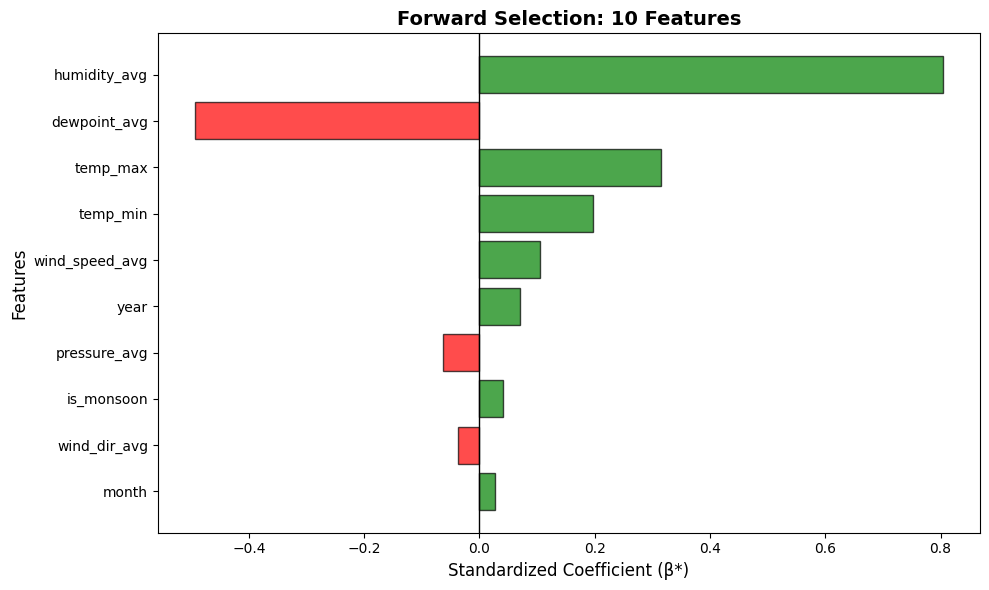


Forward Selection: 10 Features:
  humidity_avg                       :   0.803603
  dewpoint_avg                       :  -0.493309
  temp_max                           :   0.315809
  temp_min                           :   0.197232
  wind_speed_avg                     :   0.104645
  year                               :   0.070119
  pressure_avg                       :  -0.062834
  is_monsoon                         :   0.040194
  wind_dir_avg                       :  -0.037202
  month                              :   0.026915


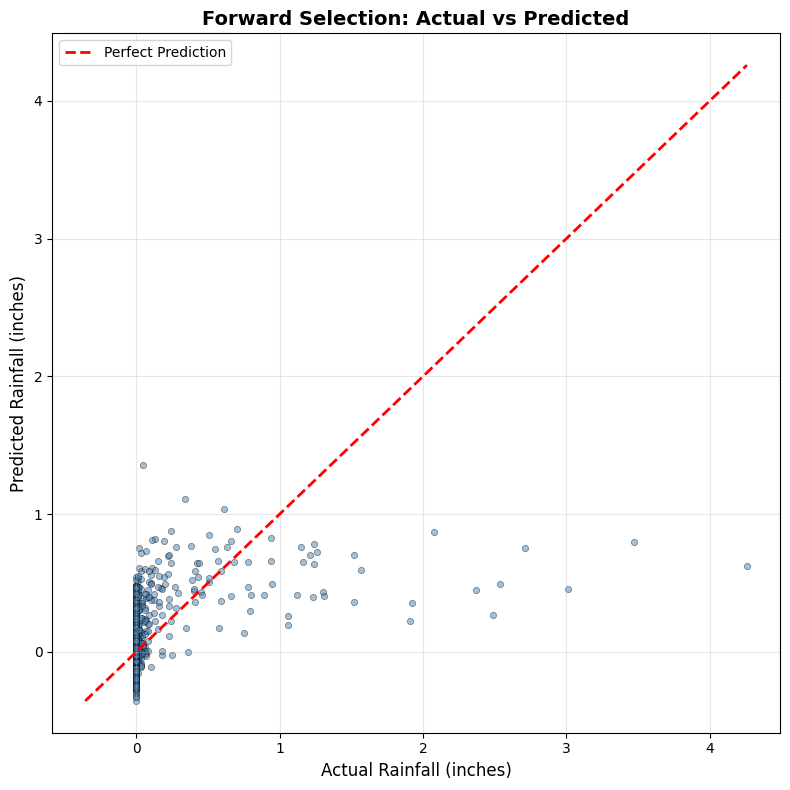

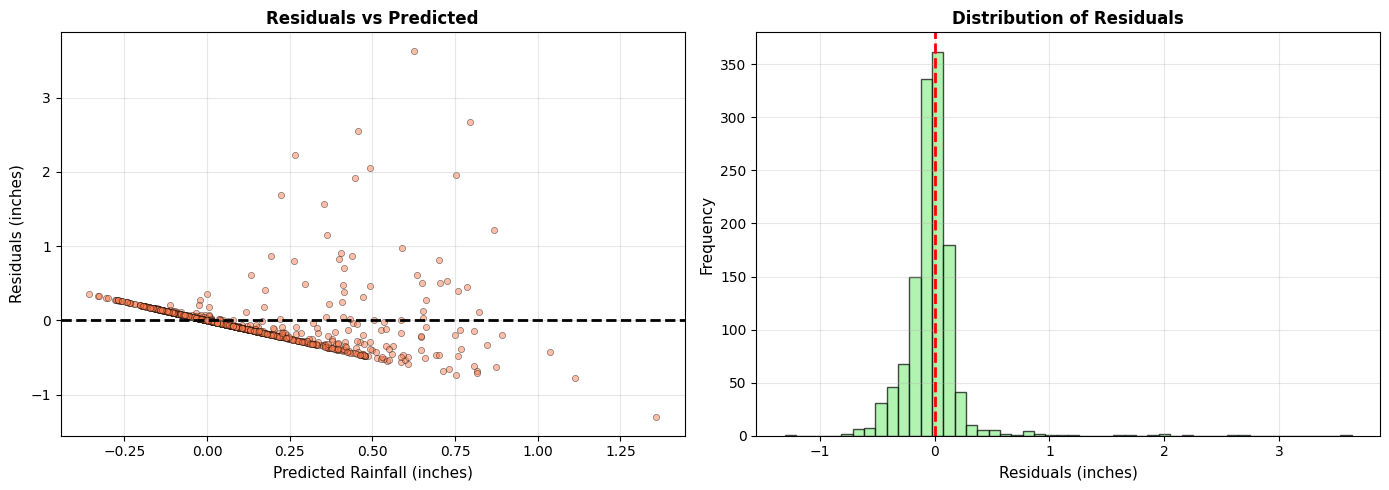

In [37]:
# Next, I will do feature (forward) selection like in the demo. I think this is helpful in finding the most optimized subset
k_select = 10 # as I virtually think 6 of the features are redundant or inter dependent
print(f"Target: Select top {k_select} features using forward selection with CV")

# Standardize for fair feature selection
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train),
    columns=feature_cols,
    index=X_train.index
)

# Forward selection with cross-validation
print(f"\nRunning forward selection with 5-fold CV...")
print("(This may take a few minutes...)")

sfs_forward = SequentialFeatureSelector(
    LinearRegression(),
    n_features_to_select=k_select,
    direction='forward',
    scoring='r2',
    cv=cv5,
    n_jobs=-1
)

sfs_forward.fit(X_train_scaled, y_train)

# Get selected features
forward_mask = sfs_forward.get_support()
forward_features = [f for f, m in zip(feature_cols, forward_mask) if m]

print(f"\nForward selection complete!")
print(f"\nSelected features ({len(forward_features)}):")
for i, feat in enumerate(forward_features, 1):
    print(f"  {i:2d}. {feat}")

# Train model with selected features
model_forward, y_pred_forward, r2_forward, mse_forward, rmse_forward, mae_forward, _, _ = model_results(
    f"Forward Selection Model: {k_select} Features",
    LinearRegression(),
    X_train[forward_features], X_test[forward_features],
    y_train, y_test,
    forward_features
)

plot_standardized_coefs(model_forward, X_train[forward_features], y_train,
                       forward_features,
                       title=f"Forward Selection: {k_select} Features")

plot_predictions(y_test, y_pred_forward, "Forward Selection: Actual vs Predicted")
plot_residuals(y_test, y_pred_forward, "Forward Selection: Residual Analysis")


Inference for this model (Forward Selection - 10 Features):

Performance vs Complexity: The model achieves R² = 0.120 using only 10 features, nearly matching the full model's R² = 0.128 with 16 features, demonstrating that 6 features were redundant as expected, and the optimized subset provides comparable accuracy with reduced complexity.

Key Predictors Identified: The selection process confirmed humidity (β* = 0.804), dewpoint (β* = -0.493), and temperature extremes (temp_max β* = 0.316, temp_min β* = 0.197) as the most important rainfall predictors, validating that moisture availability and atmospheric temperature are the fundamental drivers. Also confirmed from previous model.

Optimal Model Choice: This 10-feature model represents the best balance between predictive power and simplicity, avoiding potential overfitting from the full model while maintaining strong performance, making it the recommended model for Arizona rainfall prediction.

# Step 3 - Model Evaluation


In [38]:
# we will first analyze and summarize the 4 models that we progressively built

# Summary table
results_df = pd.DataFrame({
    'Model': [
        'Baseline (1 feature)',
        'Two Features',
        f'Full ({len(feature_cols)} features)',
        f'Forward Selection ({k_select} features)'
    ],
    'Features': [
        'pressure_change',
        'is_monsoon, humidity_avg',
        'All features',
        ', '.join(forward_features[:3]) + '...'
    ],
    'R²': [r2_baseline, r2_two, r2_full, r2_forward],
    'RMSE': [rmse_baseline, rmse_two, rmse_full, rmse_forward],
    'MAE': [mae_baseline, mae_two, mae_full, mae_forward]
})

print("\nMODEL COMPARISON SUMMARY:")
print("="*80)
print(results_df.to_string(index=False))

# Find best model
best_model_idx = results_df['R²'].idxmax()
best_model_name = results_df.loc[best_model_idx, 'Model']
best_r2 = results_df.loc[best_model_idx, 'R²']

print(f"\n{'='*80}")
print(f"BEST MODEL: {best_model_name}")
print(f"R² Score: {best_r2:.6f}")
print(f"{'='*80}")


MODEL COMPARISON SUMMARY:
                          Model                            Features        R²     RMSE      MAE
           Baseline (1 feature)                     pressure_change -0.011282 0.297777 0.134027
                   Two Features            is_monsoon, humidity_avg  0.088755 0.282666 0.147810
             Full (16 features)                        All features  0.127907 0.276527 0.147291
Forward Selection (10 features) temp_min, temp_max, dewpoint_avg...  0.120499 0.277699 0.147408

BEST MODEL: Full (16 features)
R² Score: 0.127907


AS we saw, R^2 is almost same for Model 3 and 4, and outperforms the 1 and 2 significantly. Moreover, the preidiction error RMSE is least in Model 3 and 4 but not significant differentiator is what I can see. Same for MAE. Thus based on R^2, Model 4 is best because it has less features so less chaos, and only difference of 0.006 for drop of 6 features.

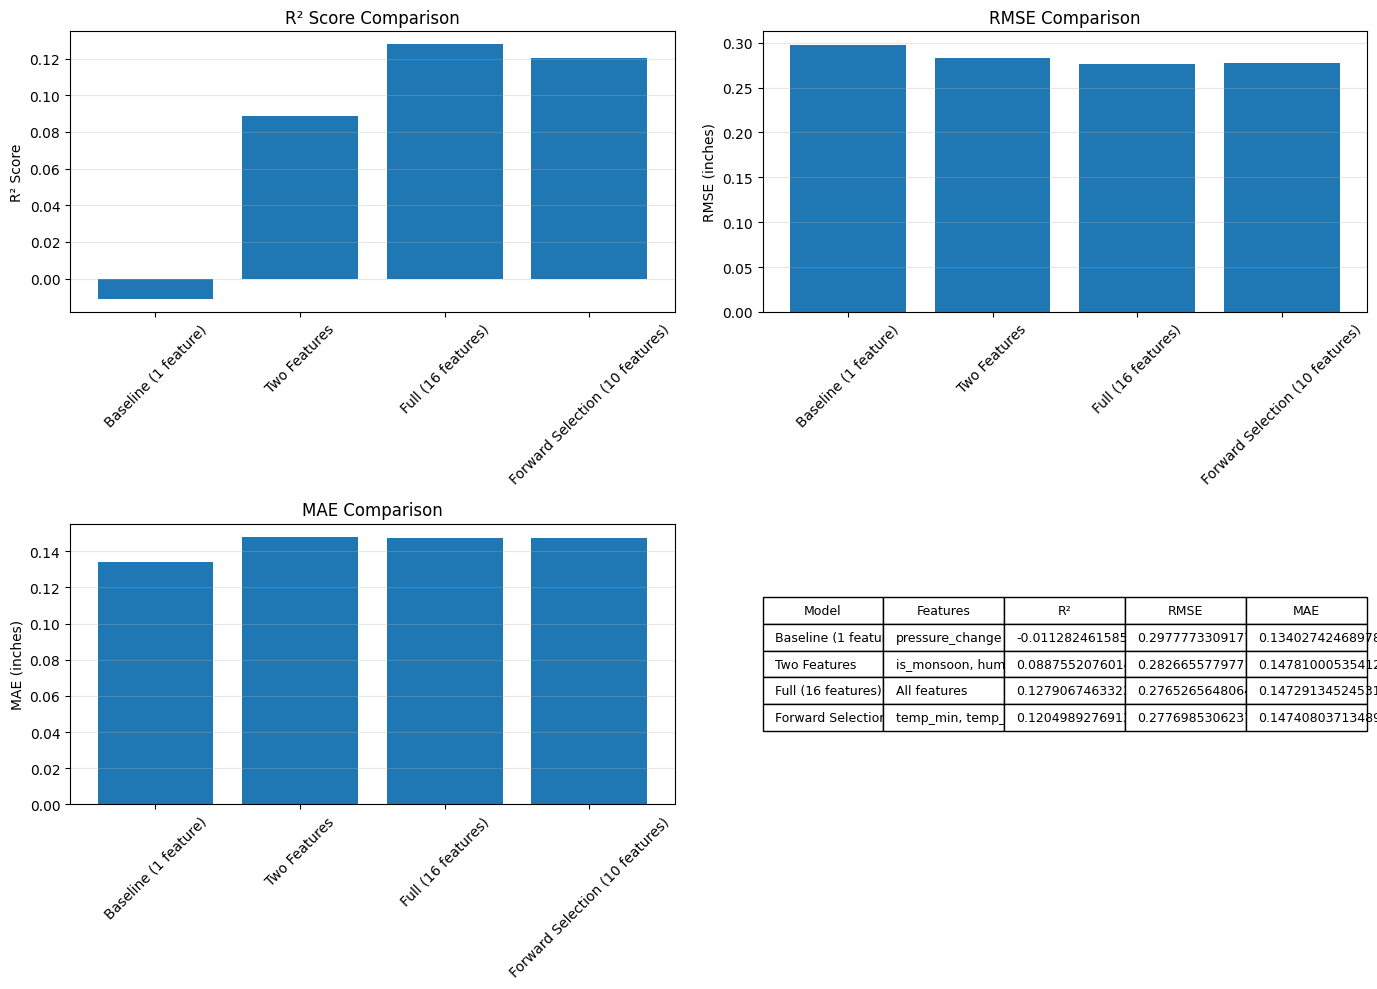

In [39]:
# Plots to show the model performances and their comparison, using simple bar plots
# R² comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0, 0].bar(results_df['Model'], results_df['R²'])
axes[0, 0].set_ylabel('R² Score')
axes[0, 0].set_title('R² Score Comparison')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(axis='y', alpha=0.3)

# RMSE comparison
axes[0, 1].bar(results_df['Model'], results_df['RMSE'])
axes[0, 1].set_ylabel('RMSE (inches)')
axes[0, 1].set_title('RMSE Comparison')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(axis='y', alpha=0.3)

# MAE comparison
axes[1, 0].bar(results_df['Model'], results_df['MAE'])
axes[1, 0].set_ylabel('MAE (inches)')
axes[1, 0].set_title('MAE Comparison')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(axis='y', alpha=0.3)

# Summary table
axes[1, 1].axis('off')
table = axes[1, 1].table(cellText=results_df.values,
                         colLabels=results_df.columns,
                         loc='center',
                         cellLoc='left')
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1, 2)

plt.tight_layout()
plt.show()

This visually corresponds to the inferences we made earlier. We are not doing ROC and Confusion matrix because that is for Logistic regression, as far as I learnt in class. End result of this milestone is that I will be using Model 4 (with 10 features) for Neural network modeling in next milestone.

# Milestone 3

Task 1: Final Model Performance Analysis

From Milestone 2's model evaluation, we found that the Multiple Linear Regression with forward selection of 10 features produced the best results.

In [40]:
# we will first analyze and summarize the 4 models that we progressively built

# Summary table
results_df = pd.DataFrame({
    'Model': [
        'Baseline (1 feature)',
        'Two Features',
        f'Full ({len(feature_cols)} features)',
        f'Forward Selection ({k_select} features)'
    ],
    'Features': [
        'pressure_change',
        'is_monsoon, humidity_avg',
        'All features',
        ', '.join(forward_features[:3]) + '...'
    ],
    'R²': [r2_baseline, r2_two, r2_full, r2_forward],
    'RMSE': [rmse_baseline, rmse_two, rmse_full, rmse_forward],
    'MAE': [mae_baseline, mae_two, mae_full, mae_forward]
})

print("\nMODEL COMPARISON SUMMARY:")
print("="*80)
print(results_df.to_string(index=False))

# Find best model
best_model_idx = results_df['R²'].idxmax()
best_model_name = results_df.loc[best_model_idx, 'Model']
best_r2 = results_df.loc[best_model_idx, 'R²']

print(f"\n{'='*80}")
print(f"BEST MODEL: {best_model_name}")
print(f"R² Score: {best_r2:.6f}")
print(f"{'='*80}")


MODEL COMPARISON SUMMARY:
                          Model                            Features        R²     RMSE      MAE
           Baseline (1 feature)                     pressure_change -0.011282 0.297777 0.134027
                   Two Features            is_monsoon, humidity_avg  0.088755 0.282666 0.147810
             Full (16 features)                        All features  0.127907 0.276527 0.147291
Forward Selection (10 features) temp_min, temp_max, dewpoint_avg...  0.120499 0.277699 0.147408

BEST MODEL: Full (16 features)
R² Score: 0.127907


AS we saw, R^2 is almost same for Model 3 and 4, and outperforms the 1 and 2 significantly. Moreover, the preidiction error RMSE is least in Model 3 and 4 but not significant differentiator is what I can see. Same for MAE. Thus based on R^2, Model 4 is best because it has less features so less chaos, and only difference of 0.006 for drop of 6 features.

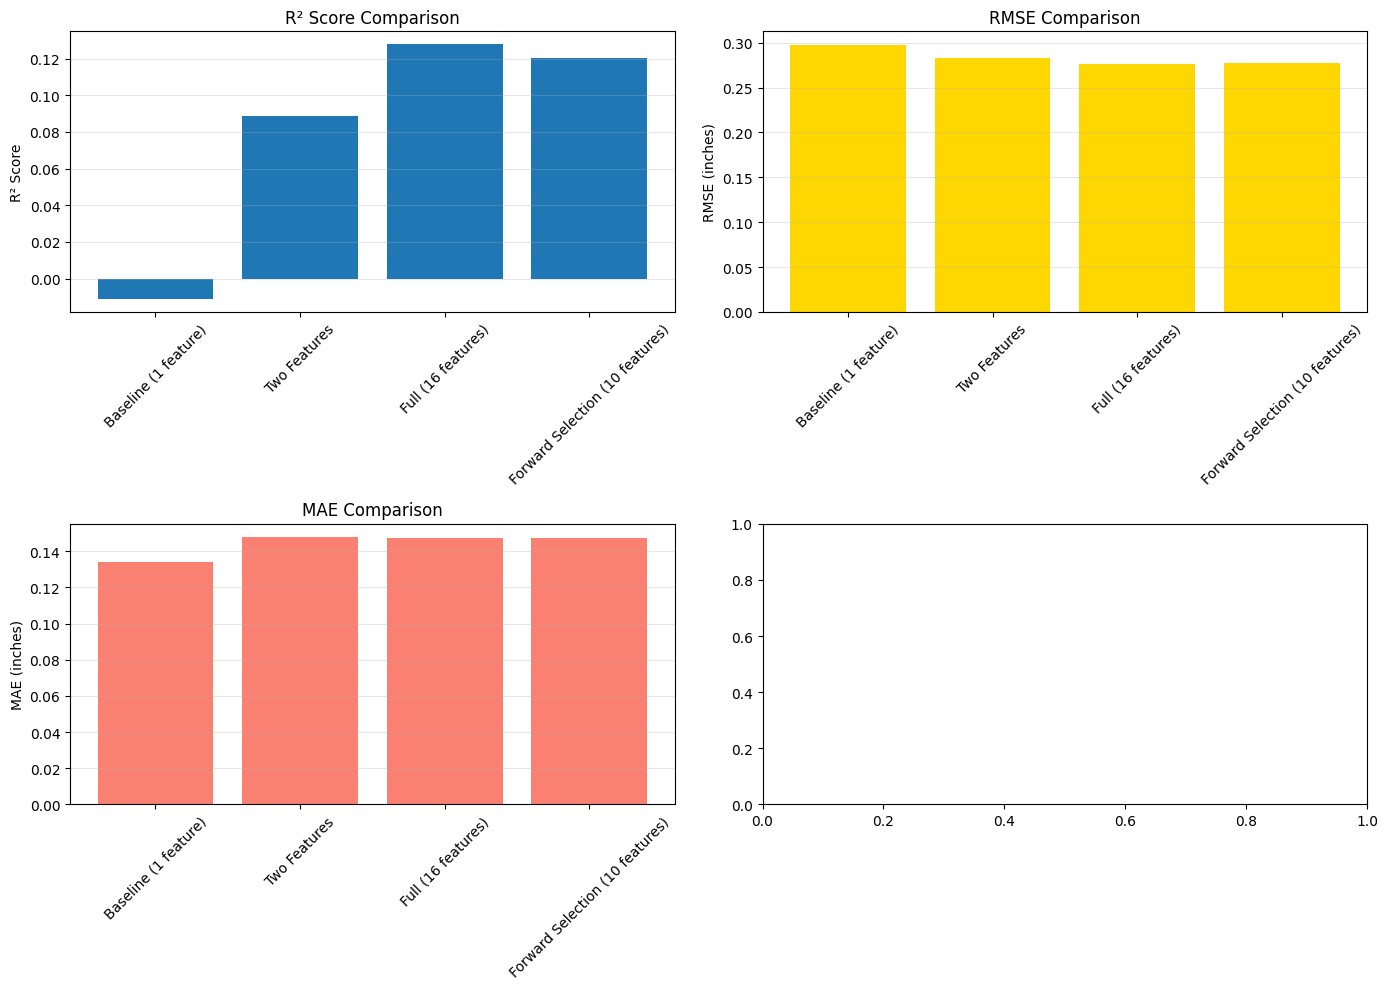

In [44]:
# Let us do some more visual comparisons between the performance of the 4 models to see
# which indicators differ the most
# Plots to show the model performances and their comparison, using simple bar plots
# R² comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0, 0].bar(results_df['Model'], results_df['R²'])
axes[0, 0].set_ylabel('R² Score')
axes[0, 0].set_title('R² Score Comparison')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(axis='y', alpha=0.3)

# RMSE comparison
axes[0, 1].bar(results_df['Model'], results_df['RMSE'], color = "gold") # wanted to see how it looks lol
axes[0, 1].set_ylabel('RMSE (inches)')
axes[0, 1].set_title('RMSE Comparison')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(axis='y', alpha=0.3)

# MAE comparison
axes[1, 0].bar(results_df['Model'], results_df['MAE'], color = "salmon")
axes[1, 0].set_ylabel('MAE (inches)')
axes[1, 0].set_title('MAE Comparison')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(axis='y', alpha=0.3)


plt.tight_layout()
plt.show()

This visually corresponds to the inferences we made earlier. We are not doing ROC and Confusion matrix because that is for Logistic regression, as far as I learnt in class. End result of this milestone is that I will be using Model 4 (with 10 features) for Neural network modeling in next milestone.

What are the most important 5 features inside these 10 features?

In [45]:
# this can be done by creating a dict with feature: abs(coefficient of that feature in forward selection)
feature_importance = dict(zip(forward_features,
                             abs(model_forward.coef_)))

# then we sort this dict by its items which are the coefficients
sorted_importance = sorted(feature_importance.items(),
                          key=lambda x: x[1], reverse=True)

print("\nTop 5 Most Important Features:")
for i, (feat, importance) in enumerate(sorted_importance[:5], 1):
    print(f"{i}. {feat}: {importance:.6f}")


Top 5 Most Important Features:
1. is_monsoon: 0.051608
2. wind_speed_avg: 0.024132
3. humidity_avg: 0.023192
4. dewpoint_avg: 0.018837
5. temp_max: 0.010346


Limitations & Final Analysis of our model -
1. R^2 score = 0.120
The model explains ~12% of the variance in rainfall. This is a low score, indicating poor predictive power. This is because rainfall in AZ is not strongly dependent on any factors as seen from the features and their coefficients. It is relatively higher than the other 3 models.

2. RMSE = 0.278
On average, predictions are off by ~0.28 inches. Given that daily rainfall is often 0 or very low, this error is quite big and significant for this model. On industrial basis and demo examples, this must be as low as 0.0x%. 0.28 inches of error is concerning given the range of our taget variable itself is [0, 7] around.

3. Model limitations
As we know, Multiple Linear Regression comes with its costs. Whenever the datapoints are not linearly separable, the model will not behave as expected. And in this research, we know that Weather relationships are very dynamic and non-linear. For example, drop in pressure and rainfall is connected by Navier Stokes Equation (just googled this), but these two have shown no connection in our linear model. This is a major drawback.

4. Poor data collection
There were so many rows that had NA values in different important columns, noticed when I was doing the Data Cleaning part. Cumulatively, this is bad for the model because it feeds on that data, and if there are a lot of NA values and we remove all, we are left with a lot less input data. We might fill these NA values with the 75% quartile method that prof was talking in class, but that will no doubt increase the complexity

# Step 2: Model Deployment Plan

First, I will begin by providing what an optimistic/ideal deployment plan for such a model would look like:

1. Frontend (Streamlit)
Interface: This is a python library that I've used for my personal projects as well. This provides a good front end and UI for terminal based or notebook projects. Simple form for users to input weather variables (Temperature, Humidity, Wind Speed, etc.).
Visualization: Display the predicted rainfall value and potentially a confidence interval or "Rain/No Rain" probability.

2. Backend (Python)
Model Serving: The trained sklearn model that we created above will be loaded into memory.
Preprocessing: Inputs must be scaled using the same StandardScaler parameters (mean, std) derived from the training set. This is important because this prevents manually coding for input verification.

3. Infrastructure
Streamlit Cloud. This feature, which I used for my e-commerce platform, connects directly to the GitHub repository. Handles hosting and HTTPS as well.



Data Pipeline might look something like this:

Training: The model is trained offline and locally (in Jupyter Notebook).

Connection to frontend: The trained model and scaler input are saved as .joblib or .pickle files. These are binary files to store Python objects (output of our model)

Inference: The app loads these files on startup.

Monitoring, scalability and maintenance:

Firstly, Linear regression is very fast, so there should be very less computation time and immediate results for the user. It is unlike Neural Network models that we know which take some good amount of time to classify or train the model.

Secondly, monitoring the data pipeline is important because occasionally errors might pop up. For example, if seaborn or scikit learn has a new update, we might face an error. Or sometimes, the csv source file does not appear automatically in the Jupyter environment. This might crash our program from the first cell itself (happened to me today).

Thirdly, maintenance is important for scalability, because new data will be collected and reported as days pass. So if we plan to improve the scope of this model, we need to maintain the pipeline such that our csv source file is online and keeps on updating in real time, or maybe doing it once a week.

Lastly, the scalibility can also be increased to other areas. For example, a really cool project could be that you specify the place you live in, and then the data pipeline will gather the source csv file from the National Centers for Environmental Information, and then our model is trained and the rainfall amount is displayed for the day that the user enters, given the other features. There are no such compliance with regulations for this project because the source is open-source, meaning any public person can download and access it, and the model is a linear regression model coded by me, and not taken from someone else.

Mock deployment

What I did was take put in 5 inputs with different values for features, ran on the model, and saw the output of the linear regression.

In [48]:
# creating the inputs (kind of trying edge cases as well)
# Create 7 different weather scenarios to test
# Each scenario represents a different day's weather conditions

scenarios = [
    {
        'name': 'Typical Summer Day',
        'temp_min': 75.0,
        'temp_max': 105.0,
        'dewpoint_avg': 55.0,
        'humidity_avg': 25.0,
        'wind_speed_avg': 5.0,
        'wind_dir_avg': 180.0,
        'pressure_avg': 1012.0,
        'month': 6,
        'year': 2024,
        'is_monsoon': 0
    },
    {
        'name': 'Monsoon Season - High Humidity',
        'temp_min': 78.0,
        'temp_max': 95.0,
        'dewpoint_avg': 68.0,
        'humidity_avg': 65.0,
        'wind_speed_avg': 8.0,
        'wind_dir_avg': 140.0,
        'pressure_avg': 1008.0,
        'month': 8,
        'year': 2024,
        'is_monsoon': 1
    },
    {
        'name': 'Cool Winter Day',
        'temp_min': 45.0,
        'temp_max': 68.0,
        'dewpoint_avg': 35.0,
        'humidity_avg': 40.0,
        'wind_speed_avg': 6.0,
        'wind_dir_avg': 220.0,
        'pressure_avg': 1015.0,
        'month': 1,
        'year': 2024,
        'is_monsoon': 0
    },
    {
        'name': 'Spring - Moderate Conditions',
        'temp_min': 62.0,
        'temp_max': 82.0,
        'dewpoint_avg': 48.0,
        'humidity_avg': 45.0,
        'wind_speed_avg': 7.0,
        'wind_dir_avg': 200.0,
        'pressure_avg': 1010.0,
        'month': 4,
        'year': 2024,
        'is_monsoon': 0
    },
    {
        'name': 'Monsoon - Low Pressure System',
        'temp_min': 72.0,
        'temp_max': 88.0,
        'dewpoint_avg': 70.0,
        'humidity_avg': 75.0,
        'wind_speed_avg': 12.0,
        'wind_dir_avg': 160.0,
        'pressure_avg': 1005.0,
        'month': 7,
        'year': 2024,
        'is_monsoon': 1
    },
    {
        'name': 'Hot Dry Day',
        'temp_min': 80.0,
        'temp_max': 110.0,
        'dewpoint_avg': 45.0,
        'humidity_avg': 15.0,
        'wind_speed_avg': 4.0,
        'wind_dir_avg': 190.0,
        'pressure_avg': 1013.0,
        'month': 9,
        'year': 2024,
        'is_monsoon': 1
    },
    {
        'name': 'Fall - Pleasant Weather',
        'temp_min': 58.0,
        'temp_max': 78.0,
        'dewpoint_avg': 42.0,
        'humidity_avg': 38.0,
        'wind_speed_avg': 5.0,
        'wind_dir_avg': 210.0,
        'pressure_avg': 1014.0,
        'month': 10,
        'year': 2024,
        'is_monsoon': 0
    }
]

# next, we will define our function that will call the model
def predict_rainfall(scenario_data, model, features):
    """
    Predict rainfall given weather scenario

    Parameters:
    - scenario_data: dict with weather features
    - model: trained model object
    - features: list of feature names in correct order

    Returns:
    - predicted rainfall in inches
    """
    # Extract features in the correct order
    input_values = [scenario_data[feat] for feat in features]

    # Convert to numpy array and reshape for model
    input_array = np.array([input_values])

    # Make prediction
    # main function from milestone 2
    prediction = model.predict(input_array)[0]

    # Ensure non-negative (can't have negative rain)
    prediction = max(0, prediction)

    return prediction

# calling the above function for our inputs
results = []
for i, scenario in enumerate(scenarios, 1):
    # Get prediction
    predicted_rainfall = predict_rainfall(scenario, model_forward, forward_features)

    # Store result
    results.append({
        'scenario': scenario['name'],
        'prediction': predicted_rainfall
    })

    # Display result
    print(f"\n{i}. {scenario['name']}")
    print(f"   Input: Temp={scenario['temp_min']:.0f}-{scenario['temp_max']:.0f}°F, "
          f"Humidity={scenario['humidity_avg']:.0f}%, "
          f"Pressure={scenario['pressure_avg']:.0f}mb")
    print(f"   → PREDICTED RAINFALL: {predicted_rainfall:.4f} inches")

    # Adding some human interpretation
    if predicted_rainfall < 0.01:
        print(f"   → Interpretation: No rain expected")
    elif predicted_rainfall < 0.1:
        print(f"   → Interpretation: Light rain possible")
    elif predicted_rainfall < 0.5:
        print(f"   → Interpretation: Moderate rain likely")
    else:
        print(f"   → Interpretation: Heavy rain likely")


1. Typical Summer Day
   Input: Temp=75-105°F, Humidity=25%, Pressure=1012mb
   → PREDICTED RAINFALL: 0.0000 inches
   → Interpretation: No rain expected

2. Monsoon Season - High Humidity
   Input: Temp=78-95°F, Humidity=65%, Pressure=1008mb
   → PREDICTED RAINFALL: 0.6362 inches
   → Interpretation: Heavy rain likely

3. Cool Winter Day
   Input: Temp=45-68°F, Humidity=40%, Pressure=1015mb
   → PREDICTED RAINFALL: 0.0000 inches
   → Interpretation: No rain expected

4. Spring - Moderate Conditions
   Input: Temp=62-82°F, Humidity=45%, Pressure=1010mb
   → PREDICTED RAINFALL: 0.1758 inches
   → Interpretation: Moderate rain likely

5. Monsoon - Low Pressure System
   Input: Temp=72-88°F, Humidity=75%, Pressure=1005mb
   → PREDICTED RAINFALL: 0.8230 inches
   → Interpretation: Heavy rain likely

6. Hot Dry Day
   Input: Temp=80-110°F, Humidity=15%, Pressure=1013mb
   → PREDICTED RAINFALL: 0.0000 inches
   → Interpretation: No rain expected

7. Fall - Pleasant Weather
   Input: Temp=58

As you can see from the output above, the model is doing actually well in the predictions and the regression values being generated.

Pipeline used above:

1. **Input preparation**: Converting our input/scenario dict → numpy array to become an appropriate input
2. **Model call**: `model_forward.predict(input_array)`in the model.predict() function that is the main function calling the model, from milestone 2
3. **Output**: Get predicted rainfall
4. **Post-processing**: Ensure non-negative predicted rainfall



Mock deployment explanation
Video link - https://asu.zoom.us/rec/share/xZ-mt6Rw0wt0q7dw3q2uNzepbudpBs3BOTa3EmqfsN1fMxjdvN8POIw5FcA4t15k.rVNvt_I-FjjpaCQV


# Step 3: Ethical Considerations

1. Bias in data on geographic and socio-cultural level
- The model is trained on data from specific Arizona weather stations, only three of them. It may not accurately predict rainfall for places like Navajo or Grand Canyon or FLagstaff, which are kind of a micro-climate, different from average climate in AZ, or underrepresented regions (e.g., rural vs. urban). By including data that the user wants to look about, we can increase the fairness of the model. I wrote more about this idea in the Monitoring section above.

- Social factors like the "rich or poor" cities might be over or under represented. This does not have anything to do with the climate majorly, but is still a small bias. This fairness can be treated by ensuring that the data is well sparsed, and splitting into training/split, and more such methods. I honestly not have the best information about treating social bias to ensure fairness.

- Historical Bias: Climate change is altering weather patterns. Training on historical data (e.g., from 2000-2020) might not reflect current or future realities, potentially leading to model underestimation of extreme events like wildfires, or other natural disasters caused by Global Warming. To treat this bias, we need our data source to be real-time: such that it involves data points of even one day ago. This will ensure fairness.


2. Impact of Errors on Stakeholders
False Negatives (Predicting No Rain when it Rains):
- In our case, showing a value like 0.003 inches as a prediction, and if it rains, the impact could be critical, but I do not think it is blamable, because weather, at the end of the day is a natural phenomena whose probability is never 1. There are 100s of better models, still no one has 100% accuracy.
- Agriculture: Farmers might irrigate unnecessarily or fail to protect crops.
- Safety: Flash floods could occur without warning if the model is relied upon for safety.
- False Positives (Predicting Rain when Dry):
Economic Loss: Cancelled outdoor events, unnecessary construction delays for a lot of different kinds stakeholders.


3. A good outcome: Reaching wider non-technical audience
Explainability: Linear regression is highly interpretable. We can explain why a prediction was made (e.g., "High humidity increased the rain forecast"). This is a strong ethical advantage over Neural net models because they involve hidden layers. It is something that is auto intiuitive I believe.


4. Privacy
- Weather data is generally public and non-sensitive. However, if user location data were collected to auto-fill inputs, that would require strict privacy controls. (Current design does not collect user data).

- More importantly, the application/platform/web app, whatever I do, I MUST clearly state that it is a student project/prototype and should NOT be used for any kind of decision-making or safety-critical applications.

Author: Anshul Kamble

Date: 10th December 2025

Thanks a lot to Dr. Atkinson and the staff for this wonderful class tho. Really learnt a lot of real-world stuff.